# Autoencoders for Anomaly Detection

We build an autoencoder to detect potential fraud on credit card data. 
We use an open-source dataset that is available on Kaggle. It has been "cleaned" and stripped of personally identifiable information.

## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

## The data

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It refers to credit card transactions occurred over two days, with 492 fraudulent ones out of 284,807.

All variables in the dataset are numerical. The data has been "obscured" using a PCA transofrmation for regulatory reasons. The two features that haven't changed are Time and Amount. Time is measured in seconds elapsed between each transaction and the first transaction in the dataset.

In [4]:
#use mount point you previously created when setting up the cluster
# Open and read the file from mounted storage
container = "data/6.Anomaly-Detection"
inputFilePath = "/dbfs/mnt/{}/{}".format(container, 'creditcard.csv') 

In [5]:
df = pd.read_csv(inputFilePath)

## Visualization

In [7]:
df.shape
display(df)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0.0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.33832076994251803,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.31116935369987897,1.46817697209427,-0.47040052525947795,0.20797124192924202,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.12853935827352803,-0.189114843888824,0.13355837674038698,-0.0210530534538215,149.62,0
0.0,1.1918571113148602,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.16697441400461402,1.6127266610547901,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.18336127012399397,-0.14578304132525902,-0.0690831352230203,-0.225775248033138,-0.6386719527718511,0.10128802125323402,-0.33984647552912706,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0
1.0,-1.35835406159823,-1.3401630747360902,1.77320934263119,0.3797795930343279,-0.503198133318193,1.80049938079263,0.7914609564504219,0.24767578658899103,-1.5146543226058302,0.207642865216696,0.6245014594248951,0.06608368526883099,0.7172927314108309,-0.165945922763554,2.34586494901581,-2.8900831944423104,1.10996937869599,-0.12135931319588801,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.9094122623477191,-0.689280956490685,-0.3276418337352511,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66,0
1.0,-0.9662717115720871,-0.185226008082898,1.79299333957872,-0.863291275036453,-0.0103088796030823,1.24720316752486,0.23760893977178,0.377435874652262,-1.38702406270197,-0.0549519224713749,-0.22648726383540102,0.178228225877303,0.507756869957169,-0.28792374549456,-0.631418117709045,-1.0596472454324999,-0.684092786345479,1.96577500349538,-1.2326219700892,-0.208037781160366,-0.108300452035545,0.0052735967825345295,-0.190320518742841,-1.1755753318632098,0.647376034602038,-0.22192884445840697,0.0627228487293033,0.0614576285006353,123.5,0
2.0,-1.1582330934952298,0.8777367548484508,1.548717846511,0.40303393395512105,-0.40719337731165295,0.0959214624684256,0.5929407453855451,-0.27053267719228197,0.8177393082352941,0.7530744319763539,-0.8228428779463629,0.53819555014995,1.3458515932154,-1.11966983471731,0.175121130008994,-0.451449182813529,-0.237033239362776,-0.0381947870352842,0.803486924960175,0.40854236039275804,-0.009430697132329191,0.7982784945897099,-0.13745807961906303,0.14126698382476902,-0.20600958761975602,0.502292224181569,0.219422229513348,0.21515314749920603,69.99,0
2.0,-0.425965884412454,0.960523044882985,1.1411093423221899,-0.16825207976030201,0.42098688077219004,-0.0297275516639742,0.47620094872002705,0.260314333074874,-0.56867137571251,-0.371407196834471,1.3412619800195702,0.35989383703803896,-0.35809065257363104,-0.13713370021761198,0.517616806555742,0.401725895589603,-0.0581328233640131,0.0686531494425432,-0.0331937877876282,0.0849676720682049,-0.20825351465672798,-0.5598247962532479,-0.0263976679795373,-0.371426583174346,-0.23279381673703398,0.10591477909795698,0.253844224739337,0.0810802569229443,3.67,0
4.0,1.22965763450793,0.141003507049326,0.0453707735899449,1.20261273673594,0.19188098859764496,0.272708122899098,-0.005159002882509829,0.0812129398830894,0.464959994783886,-0.0992543211289237,-1.41690724314928,-0.15382582625365102,-0.75106271556262,0.16737196252175,0.0501435942254188,-0.44358679791672706,0.00282051247234708,-0.61198733994012,-0.0455750446637976,-0.21963255278685997,-0.167716265815783,-0.270709726172363,-0.15410378680930498,-0.7800554150046709,0.75013693580659,-0.25723684591713897,0.0345074297438413,0.0051677689062491605,4.99,0
7.0,-0.644269442348146,1.4179635454738502,1.0743803763556

31 columns, of which Time, Amount and Class (normal/fraudulent) intelligible. The rest are output from a PCA transformation. There are no missing values.

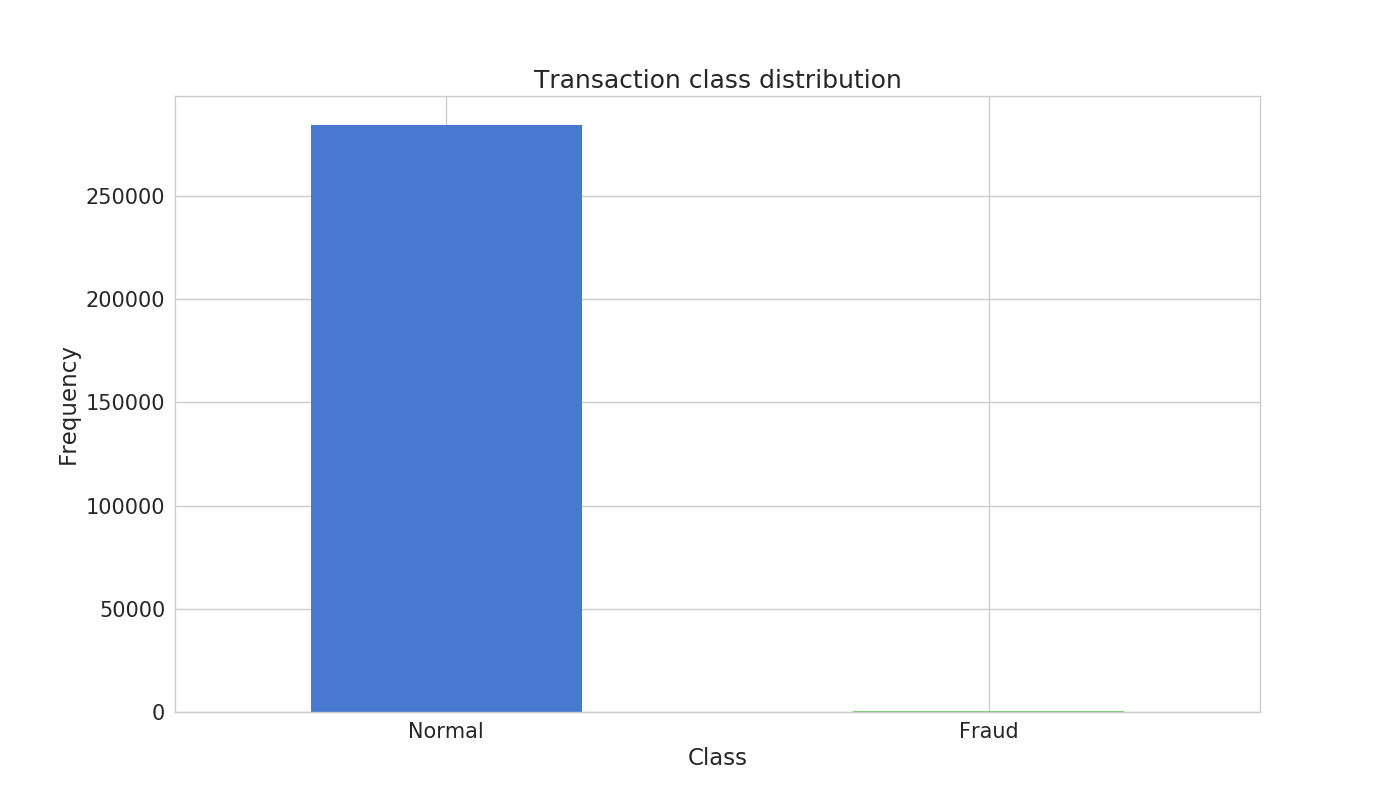

In [9]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
display()

The dataset is highly imbalanced. That is to be expected: we are looking for anomalies and those are by definition rare. It would be really problematic if fraud was a significant percentage of the transactions!

In [11]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [12]:
frauds.shape

Out[9]: (492, 31)

In [13]:
normal.shape

Out[10]: (284315, 31)

In [14]:
frauds.Amount.describe()

Out[11]: 
count 492.000000
mean 122.211321
std 256.683288
min 0.000000
25% 1.000000
50% 9.250000
75% 105.890000
max 2125.870000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

Out[12]: 
count 284315.000000
mean 88.291022
std 250.105092
min 0.000000
25% 5.650000
50% 22.000000
75% 77.050000
max 25691.160000
Name: Amount, dtype: float64

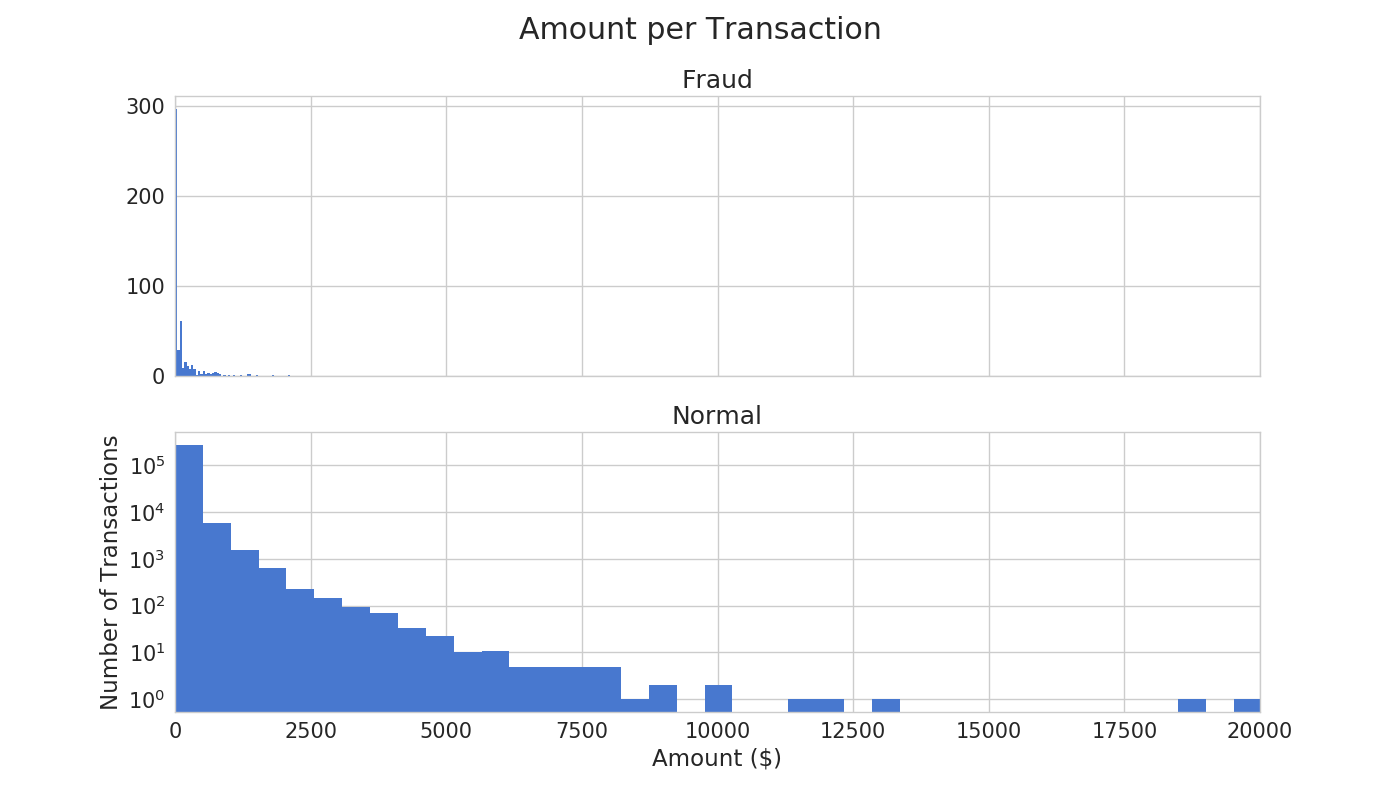

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per Transaction')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()
display()

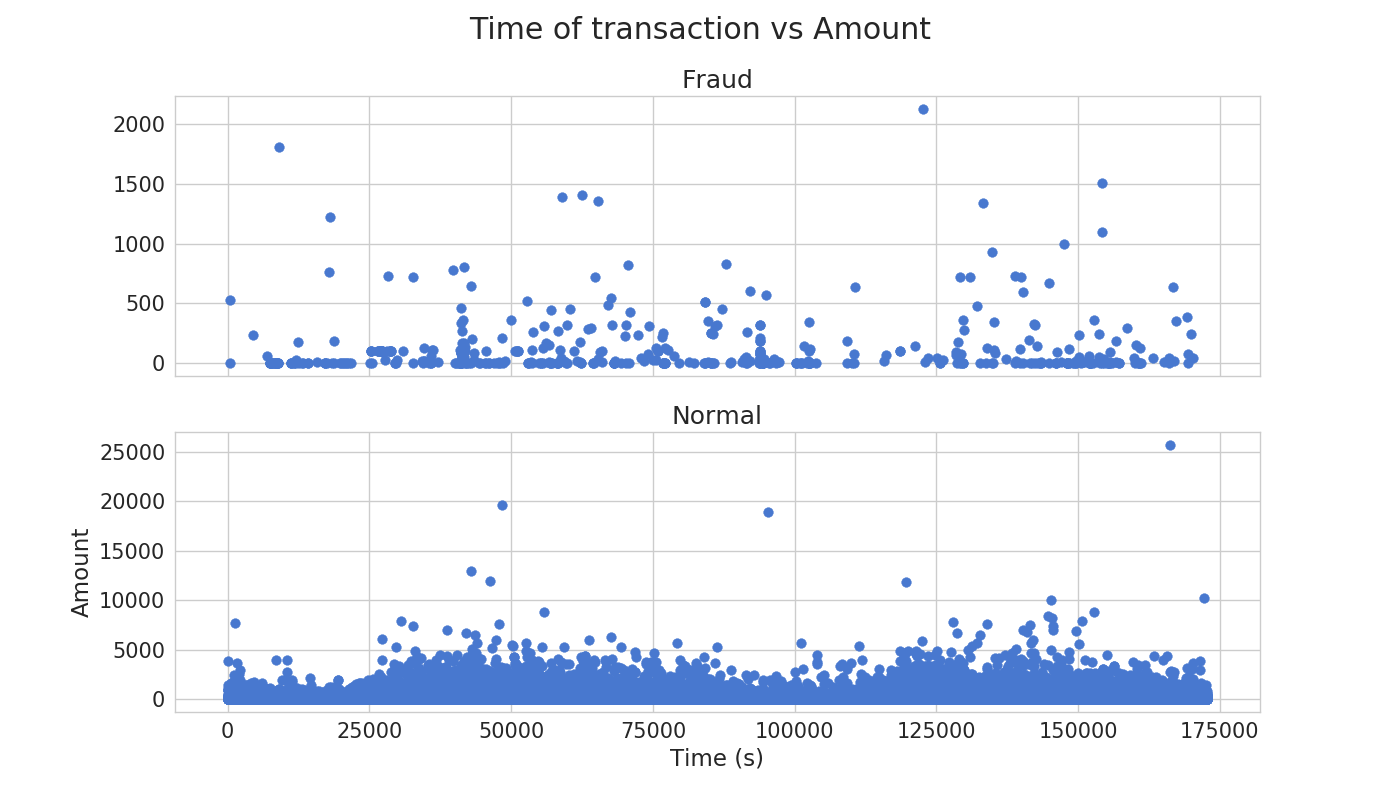

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (s)')
plt.ylabel('Amount')
plt.show()
display()

It looks like fraudulent transactions tend to be for small amounts, and time doesn't seem to matter.

## Autoencoders

We want to build an undercomplete autoencoder that learns the characteristics  of a normal transaction.

## Reconstruction error

We optimize its parameters to minimize the reconstruction error, which in this case we'll measure with MSE.

## Data preparation

Time does not seem important, so we'll drop it. We'll also normalize the amount to unit variance in order to limit bias.

In [20]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

We split the data set 80/20% and select normal transactions (class=0), because we want the autoencoder to learn that representation only.
We also drop the class value, because the autoencoder is unsupervised.

In [22]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [23]:
X_train.shape

Out[18]: (227451, 29)

## Building the model

We use fully connected layers with 22, 15, 10, 15 and 22 neurons respectively.  The first two layers are used for the encoder, the last two for the decoder. L1 regularization will be used during training:

In [25]:
input_dim = X_train.shape[1]
encoding_dim = 22

In [26]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu" 
                #activity_regularizer=regularizers.l1(10e-5)
               )(input_layer)
encoder = Dense(int(15), activation="relu")(encoder)
encoder = Dense(int(10), activation="relu")(encoder)

decoder = Dense(int(15), activation="relu")(encoder)

decoder = Dense(int(encoding_dim), activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

We train the model for 150 epochs with a batch size of 32 samples and save the best to a file using a checkpoint callback.

In [28]:
nb_epoch = 150
batch_size = 32
outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'autoencoder.h5')

autoencoder.compile(optimizer='adam', 
                    loss='mse')

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=10,
                         verbose=1,
                         restore_best_weights=True
                         )

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/150

 32/227451 [..............................] - ETA: 58:00 - loss: 0.8791
 608/227451 [..............................] - ETA: 3:21 - loss: 0.9709 
 1216/227451 [..............................] - ETA: 1:50 - loss: 1.0058
 1792/227451 [..............................] - ETA: 1:21 - loss: 1.0143
 2400/227451 [..............................] - ETA: 1:05 - loss: 0.9979
 3008/227451 [..............................] - ETA: 55s - loss: 1.0538 
 3616/227451 [..............................] - ETA: 49s - loss: 1.0547
 4224/227451 [..............................] - ETA: 45s - loss: 1.0399
 4832/227451 [..............................] - ETA: 41s - loss: 1.0148
 5408/227451 [..............................] - ETA: 39s - loss: 0.9922
 6016/227451 [..............................] - ETA: 37s - loss: 0.9864
 6624/227451 [..............................] - ETA: 35s - loss: 0.9673
 7232/227451 [..............................] - ETA: 33s - loss: 0.9476
 7840/227451 [>.............................] - ETA: 32s - loss: 0.9420
 8448/227451 [>.............................] - ETA: 31s - loss: 0.9329
 9056/227451 [>.............................] - ETA: 30s - loss: 0.9314
 9664/227451 [>.............................] - ETA: 29s - loss: 0.9168
 10240/227451 [>.............................] - ETA: 29s - loss: 0.9004
 10848/227451 [>.............................] - ETA: 28s - loss: 0.8952
 11456/227451 [>.............................] - ETA: 27s - loss: 0.8848
 12064/227451 [>.............................] - ETA: 27s - loss: 0.8723
 12640/227451 [>.............................] - ETA: 26s - loss: 0.8634
 13248/227451 [>.............................] - ETA: 26s - loss: 0.8553
 13824/227451 [>.............................] - ETA: 25s - loss: 0.8551
 14400/227451 [>.............................] - ETA: 25s - loss: 0.8455
 15008/227451 [>.............................] - ETA: 25s - loss: 0.8432
 15616/227451 [=>............................] - ETA: 24s - loss: 0.8333
 16224/227451 [=>............................] - ETA: 24s - loss: 0.8264
 16832/227451 [=>............................] - ETA: 24s - loss: 0.8231
 17440/227451 [=>............................] - ETA: 23s - loss: 0.8176
 18048/227451 [=>............................] - ETA: 23s - loss: 0.8176
 18656/227451 [=>............................] - ETA: 23s - loss: 0.8099
 19264/227451 [=>............................] - ETA: 23s - loss: 0.8087
 19872/227451 [=>............................] - ETA: 22s - loss: 0.8033
 20480/227451 [=>............................] - ETA: 22s - loss: 0.7983
 21088/227451 [=>............................] - ETA: 22s - loss: 0.7912
 21664/227451 [=>............................] - ETA: 22s - loss: 0.7844
 22272/227451 [=>............................] - ETA: 22s - loss: 0.7779
 22848/227451 [==>...........................] - ETA: 21s - loss: 0.7734
 23456/227451 [==>...........................] - ETA: 21s - loss: 0.7681
 24064/227451 [==>...........................] - ETA: 21s - loss: 0.7628
 24672/227451 [==>...........................] - ETA: 21s - loss: 0.7582
 25280/227451 [==>...........................] - ETA: 21s - loss: 0.7542
 25888/227451 [==>...........................] - ETA: 21s - loss: 0.7487
 26464/227451 [==>...........................] - ETA: 20s - loss: 0.7645
 27072/227451 [==>...........................] - ETA: 20s - loss: 0.7603
 27680/227451 [==>...........................] - ETA: 20s - loss: 0.7566
 28288/227451 [==>...........................] - ETA: 20s - loss: 0.7532
 28896/227451 [==>...........................] - ETA: 20s - loss: 0.7481
 29472/227451 [==>...........................] - ETA: 20s - loss: 0.7438
 30080/227451 [==>...........................] - ETA: 20s - loss: 0.7417
 30688/227451 [===>..........................] - ETA: 19s - loss: 0.7379
 31296/227451 [===>..........................] - ETA: 19s - loss: 0.7334
 31904/227451 [===>..........................] - ETA: 19s - loss: 0.7292
 32480

In [29]:
# load the best model back
#autoencoder = load_model('model.h5')

## Evaluation

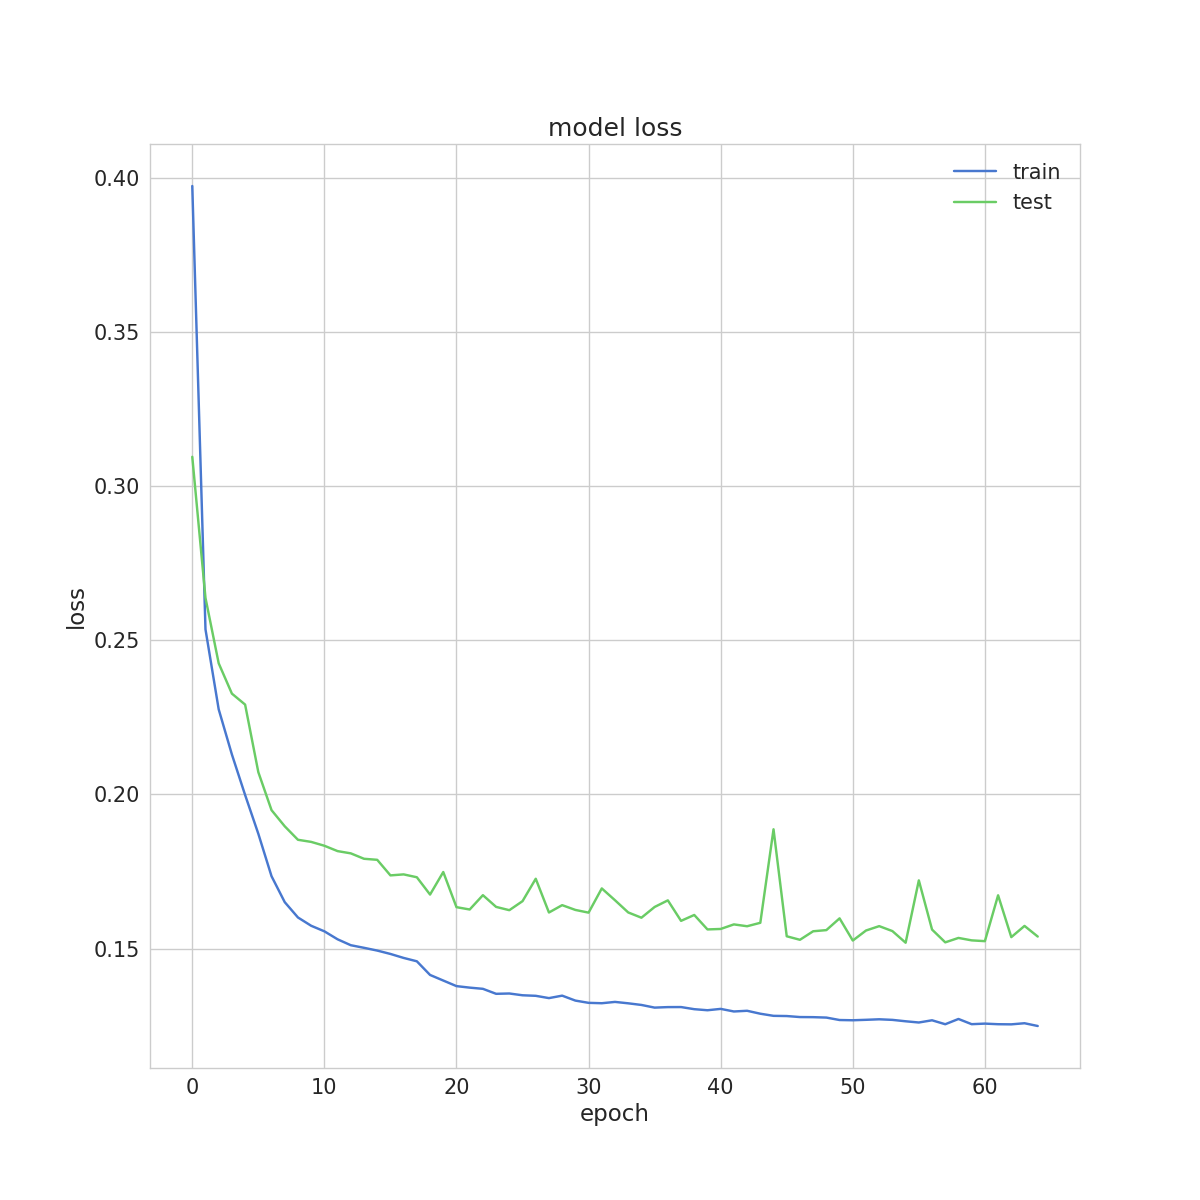

In [31]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
display()

In [32]:
predictions = autoencoder.predict(X_test)

In [33]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [34]:
error_df.describe()

Out[86]: 
 reconstruction_error true_class
count 56962.000000 56962.000000
mean 0.151904 0.001720
std 1.235753 0.041443
min 0.004369 0.000000
25% 0.039128 0.000000
50% 0.067987 0.000000
75% 0.128393 0.000000
max 62.661035 1.000000

## Reconstruction error without fraud

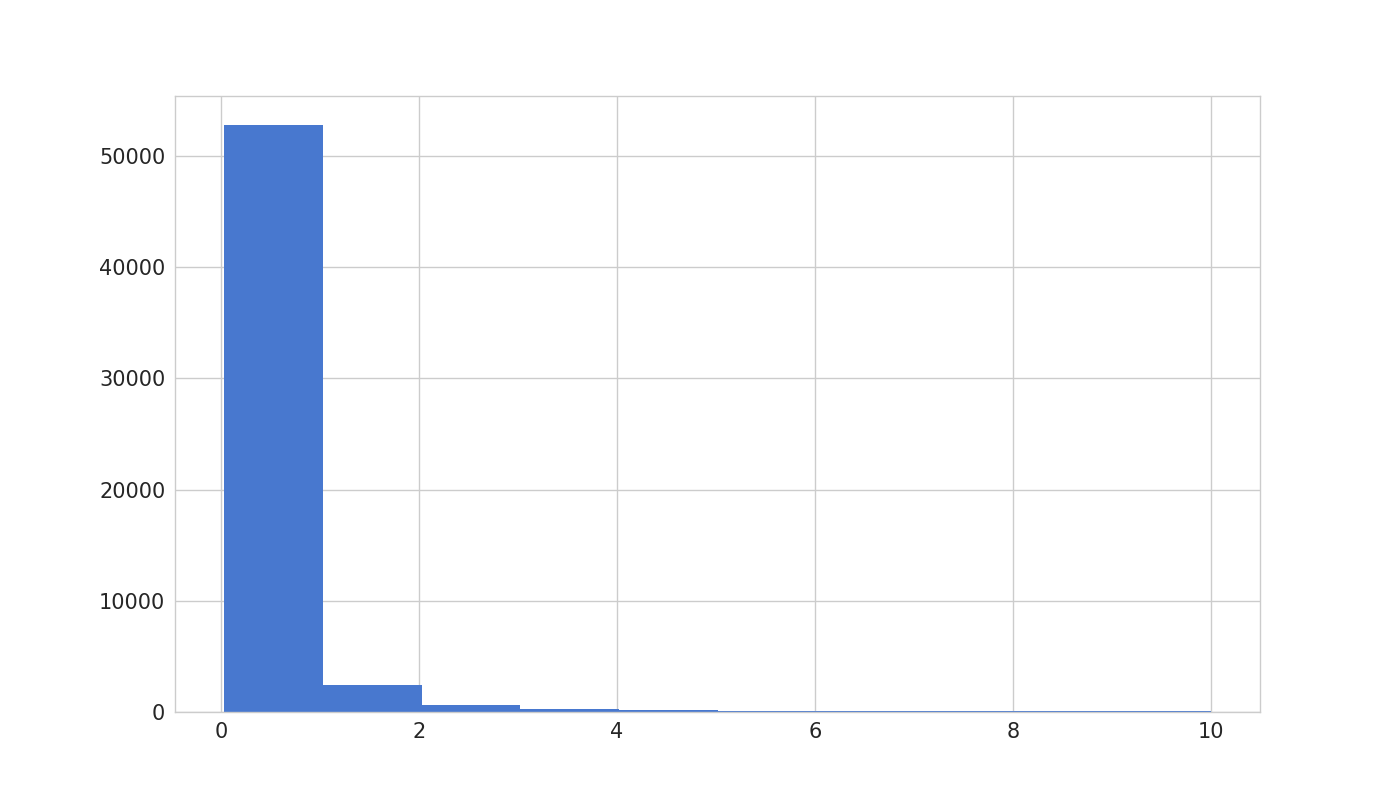

In [36]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
display()

## Reconstruction error with fraud

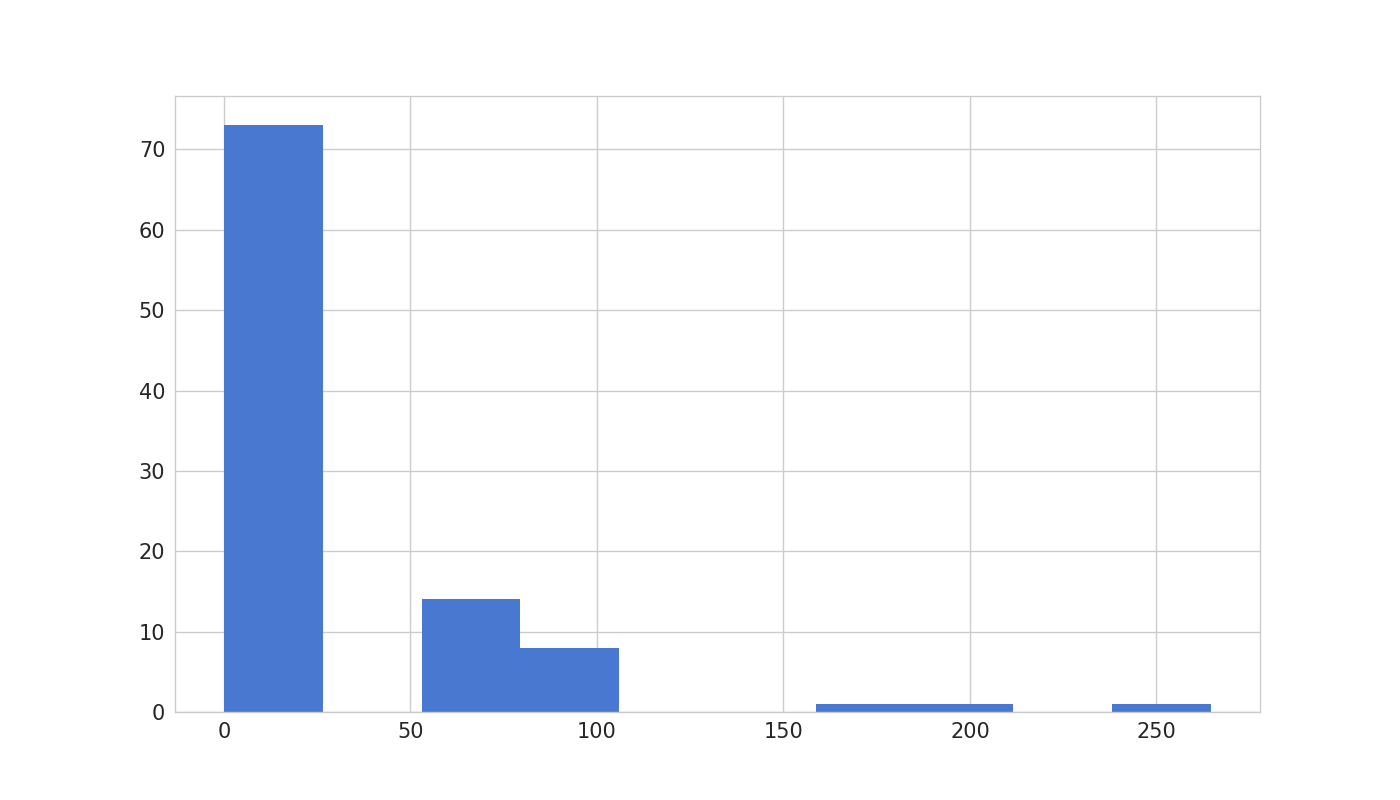

In [38]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
display()

In [39]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are not very useful in the case of anomaly detection, because the dataset is too imbalanced. Nonetheless, let's have a look at our ROC curve:

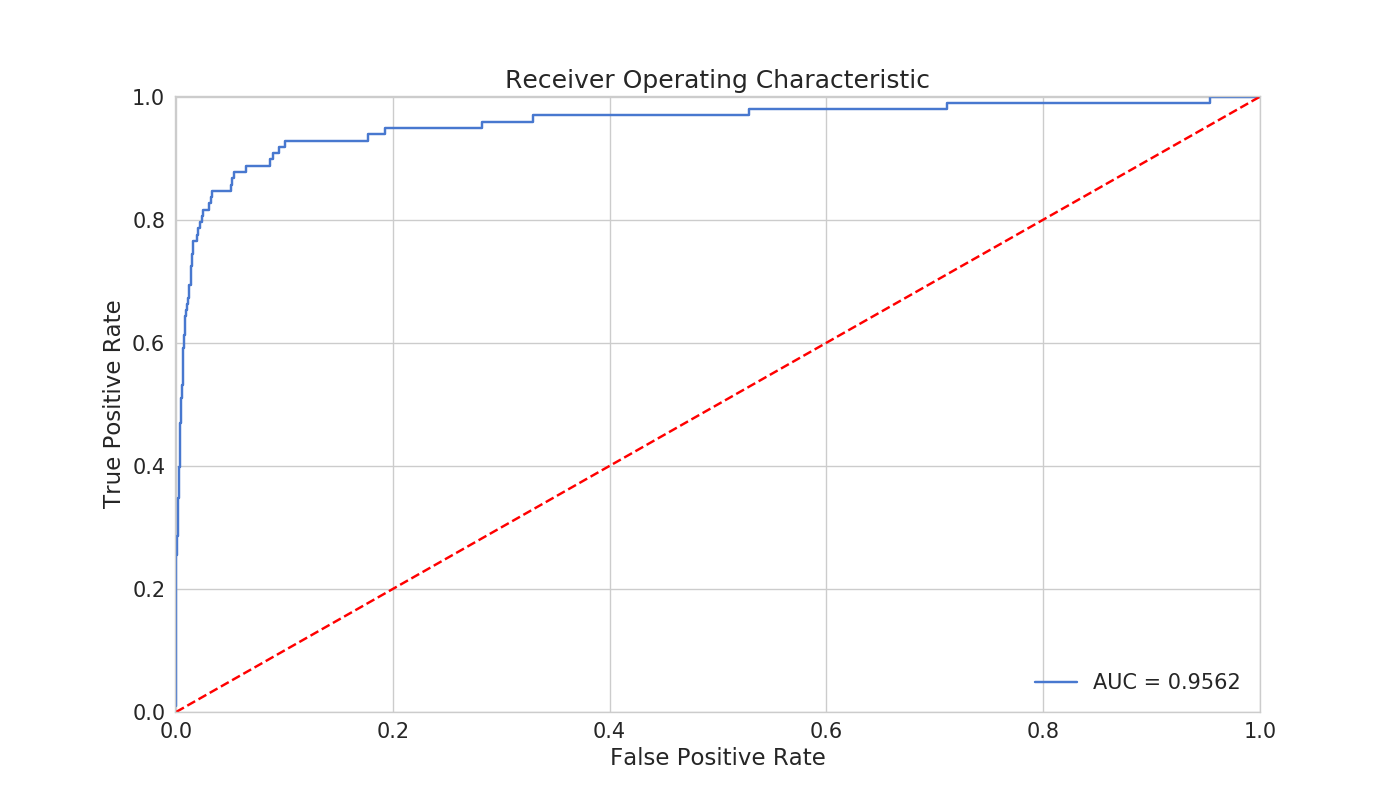

In [41]:
plt.clf()
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
display()

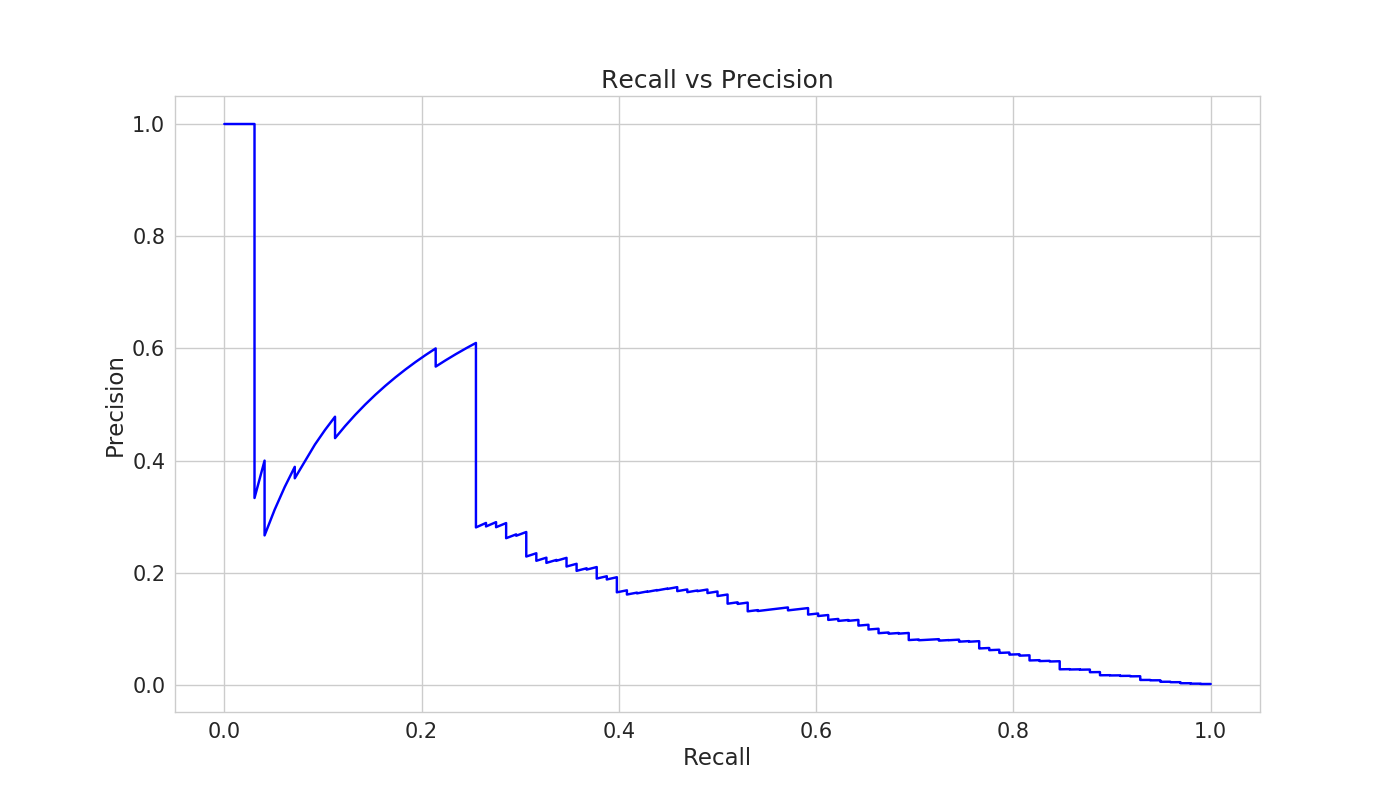

In [42]:
plt.clf()
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
display()

High precision indicates a low false positive rate, high recall a low false negative rate. Ideally we want both.

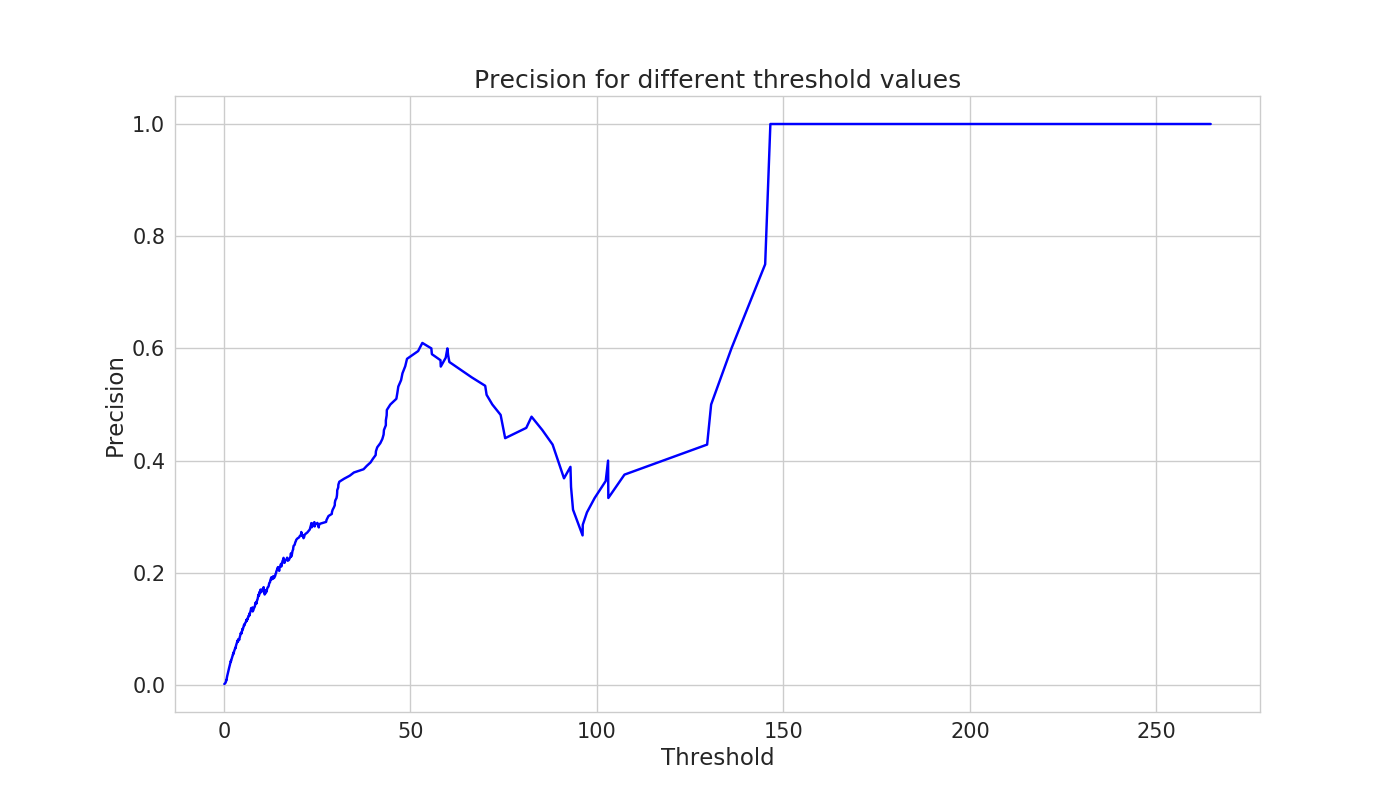

In [44]:
plt.clf()
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()
display()

As the reconstruction error increases, precision does as well.

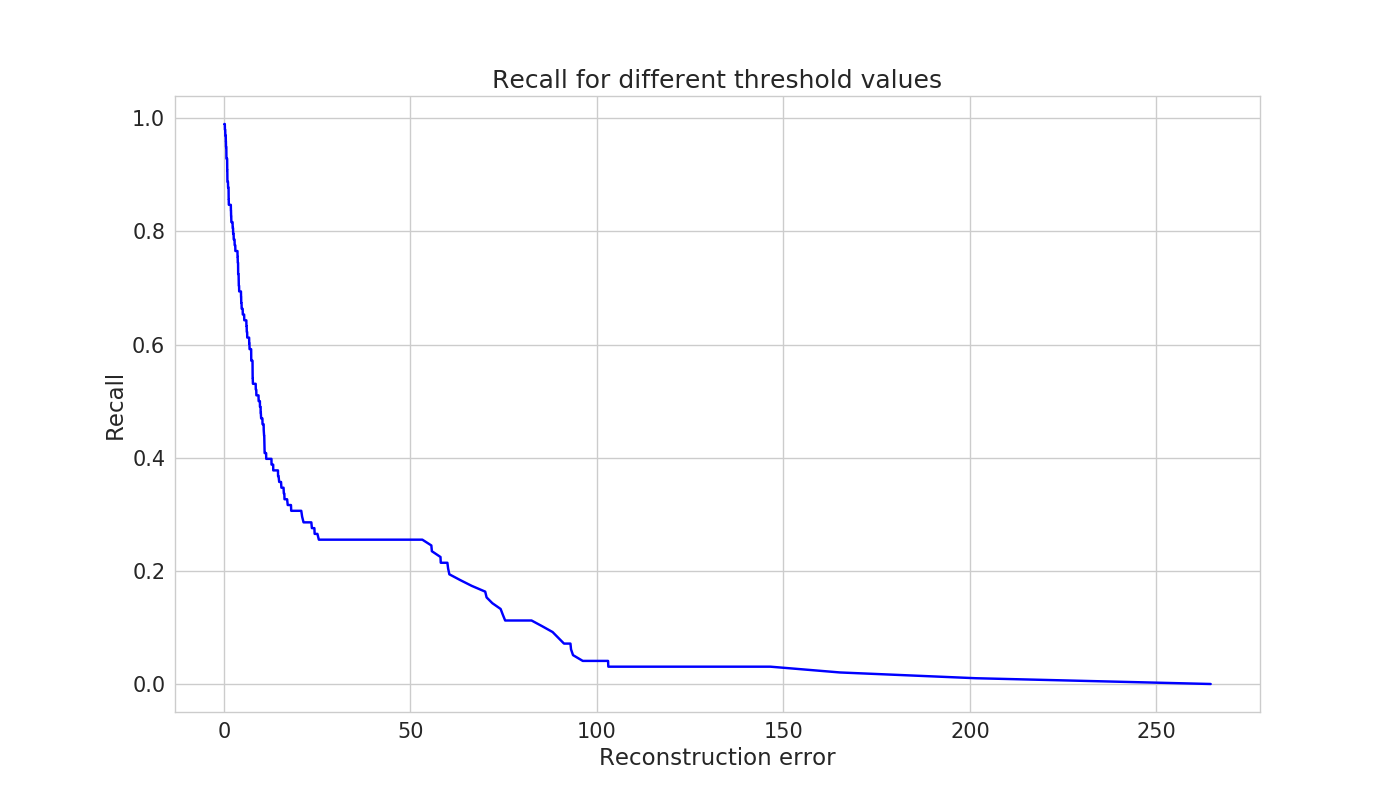

In [46]:
plt.clf()
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()
display()

As the reconstruction error increases, the recall decreases.

## Prediction

An autoencoder does not predict, it just reconstructs. In order to predict whether or not a transaction is normal or fraudulent, we calculate the reconstruction error from the transaction data. If the error is larger than a given threshold, we'll mark it as a fraud. In fact, our model was trained to reconstruct normal transactions. The reconstruction error will be higher for fraudulent ones.

In [49]:
threshold = 3.5

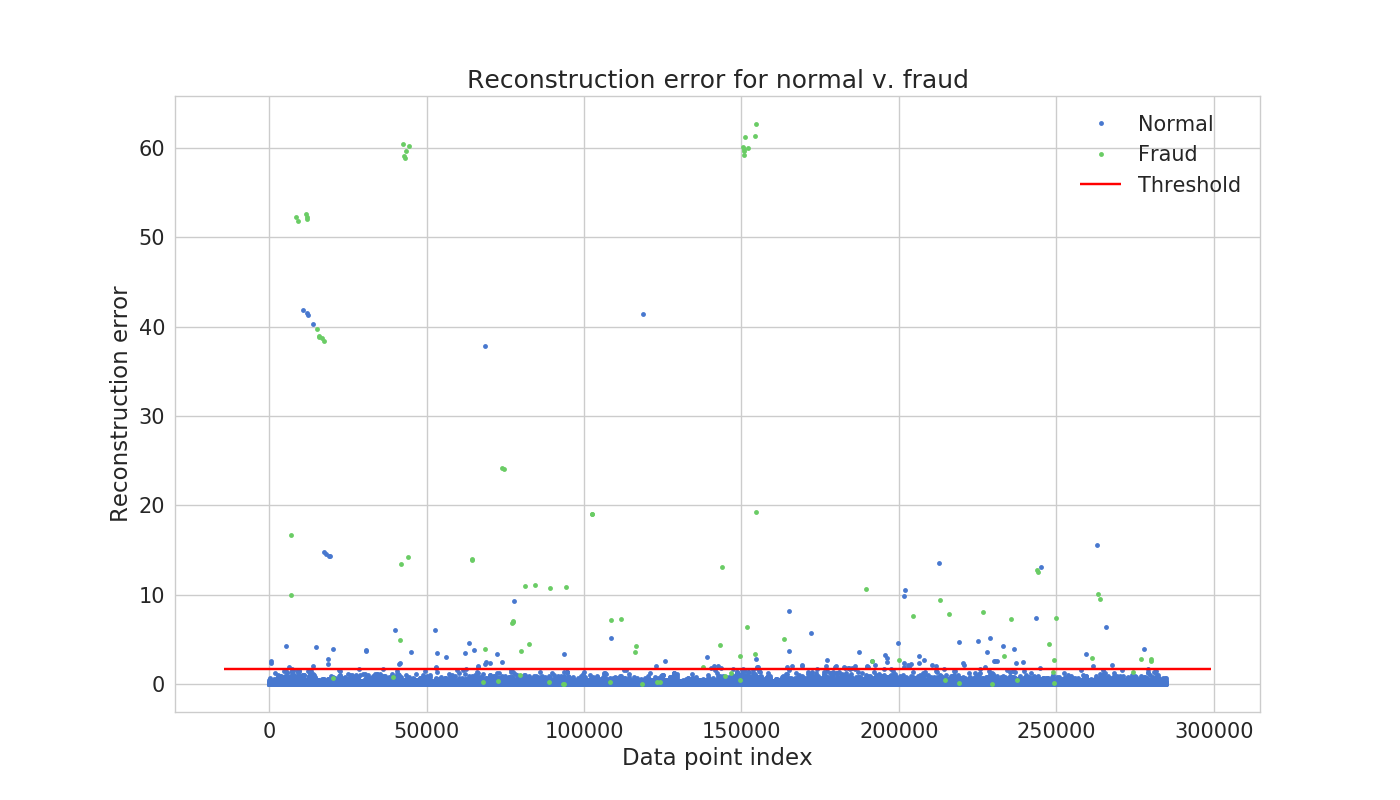

In [50]:
plt.clf()
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal v. fraud")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
display()

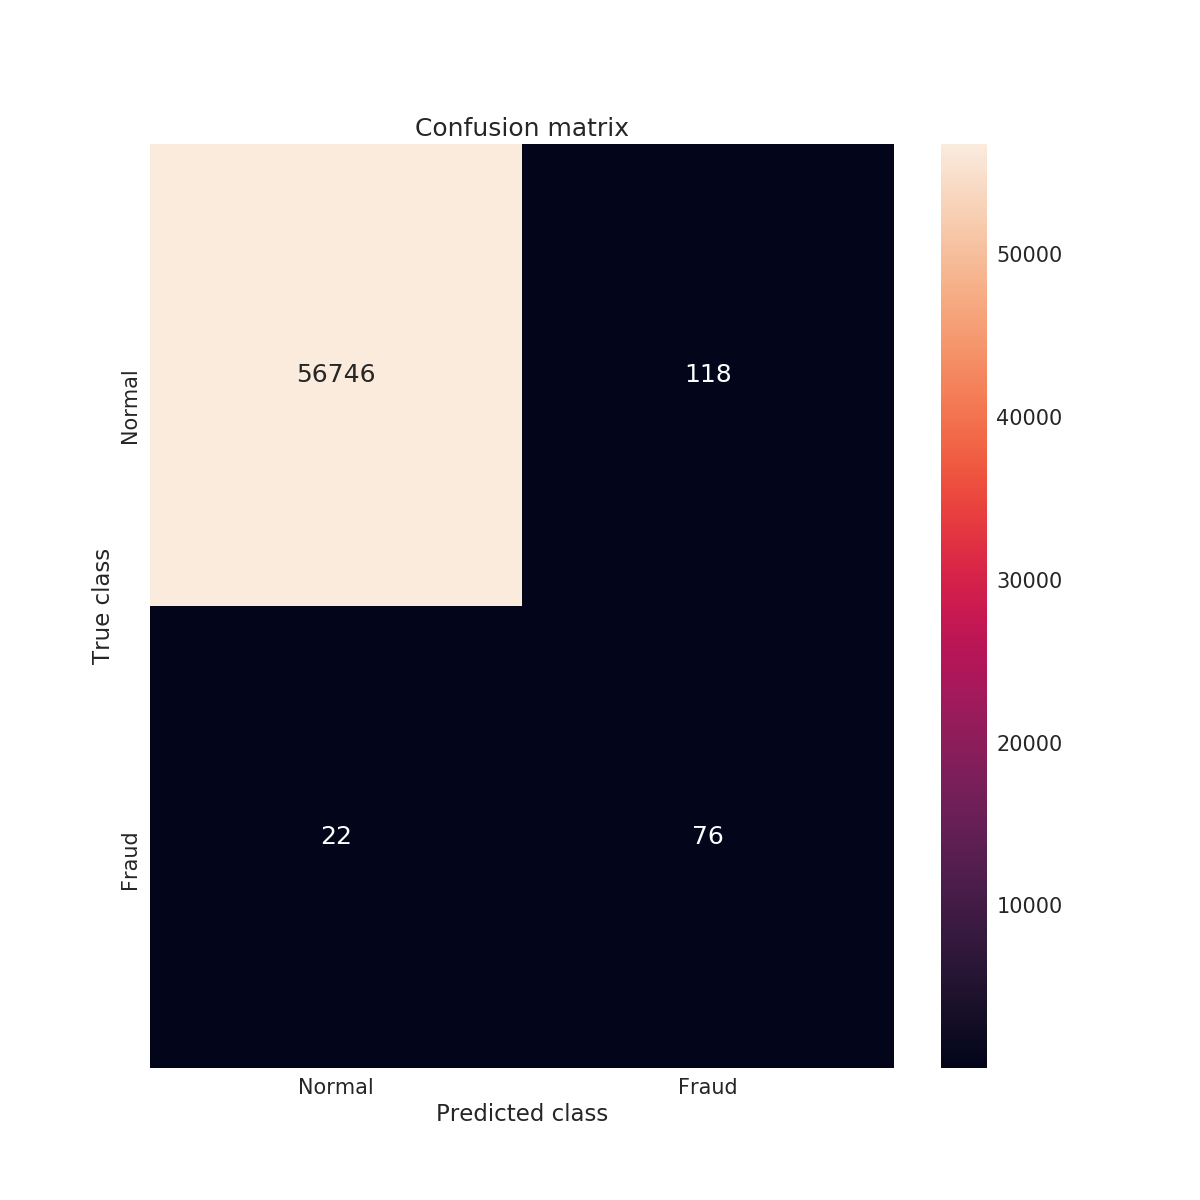

In [51]:
plt.clf()
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
display()

## Observation
The model still has quite a lot of false positives (i.e. normal transactions that were predicted to be fraudulent). Better safe than sorry, but we can do some more tuning. We add gaussian noise and train the autoencoder to filter it out.

In [53]:
def add_gaussian_noise(nparray):
    noise = np.random.normal(loc=0.0, scale=0.02, size=np.shape(nparray))
    nparray += noise
    return nparray

In [54]:
X_noisy = add_gaussian_noise(X_train)
X_noisy

Out[90]: 
array([[ 1.95627845, -0.39265628, -0.33758497, ..., 0.09960106,
 -0.06191653, -0.31047983],
 [-0.38639859, -0.63073293, 1.57128366, ..., -0.41063918,
 -0.14365016, -0.21751934],
 [ 0.11128696, 0.87911837, -0.56762524, ..., 0.22981841,
 0.08445395, -0.31872496],
 ...,
 [-0.18511806, 0.97689255, 1.55250534, ..., -0.10693528,
 -0.19815158, -0.35032309],
 [-2.97981922, 2.34989399, -2.56203542, ..., 0.48259993,
 0.3354616 , -0.37728549],
 [ 1.17246727, -0.78991051, 0.36336278, ..., -0.0491555 ,
 0.05347439, 0.12596177]])

In [55]:
from keras.layers.advanced_activations import LeakyReLU

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, 
                #activation="relu" 
                #activity_regularizer=regularizers.l1(10e-5)
               )(input_layer)
encoder=LeakyReLU(0.3)(encoder)
encoder = Dense(int(15))(encoder)
encoder=LeakyReLU(0.3)(encoder)
encoder = Dense(int(10))(encoder)
encoder=LeakyReLU(0.3)(encoder)

decoder = Dense(int(15))(encoder)
decoder=LeakyReLU(0.3)(decoder)
decoder = Dense(int(encoding_dim))(decoder)
decoder=LeakyReLU(0.3)(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [56]:
autoencoder.summary()

_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_3 (InputLayer) (None, 29) 0 
_________________________________________________________________
dense_13 (Dense) (None, 22) 660 
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU) (None, 22) 0 
_________________________________________________________________
dense_14 (Dense) (None, 15) 345 
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU) (None, 15) 0 
_________________________________________________________________
dense_15 (Dense) (None, 10) 160 
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU) (None, 10) 0 
_________________________________________________________________
dense_16 (Dense) (None, 15) 165 
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU) (None, 15) 0 
_________________________________________________________________
dense_17 (Dense) (None, 22) 352 
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU) (None, 22) 0 
_________________________________________________________________
dense_18 (Dense) (None, 29) 667 
=================================================================
Total params: 2,349
Trainable params: 2,349
Non-trainable params: 0
_________________________________________________________________

In [57]:
nb_epoch = 150
batch_size = 32

outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'denoising_autoencoder.h5')

autoencoder.compile(optimizer='adam', 
                    loss='mse')

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=10,
                         verbose=1,
                         restore_best_weights=True
                         )


history = autoencoder.fit(X_noisy, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/150

 32/227451 [..............................] - ETA: 1:07:23 - loss: 0.7421
 576/227451 [..............................] - ETA: 4:04 - loss: 0.9871 
 1120/227451 [..............................] - ETA: 2:15 - loss: 0.9727
 1664/227451 [..............................] - ETA: 1:38 - loss: 0.9548
 2208/227451 [..............................] - ETA: 1:19 - loss: 0.9771
 2688/227451 [..............................] - ETA: 1:09 - loss: 0.9438
 3232/227451 [..............................] - ETA: 1:00 - loss: 0.9327
 3776/227451 [..............................] - ETA: 55s - loss: 0.9170 
 4320/227451 [..............................] - ETA: 50s - loss: 0.8944
 4864/227451 [..............................] - ETA: 47s - loss: 0.8886
 5376/227451 [..............................] - ETA: 44s - loss: 0.8641
 5952/227451 [..............................] - ETA: 42s - loss: 0.8642
 6528/227451 [..............................] - ETA: 40s - loss: 0.8661
 7072/227451 [..............................] - ETA: 38s - loss: 0.8520
 7616/227451 [>.............................] - ETA: 37s - loss: 0.8384
 8160/227451 [>.............................] - ETA: 36s - loss: 0.8338
 8704/227451 [>.............................] - ETA: 34s - loss: 0.8249
 9248/227451 [>.............................] - ETA: 33s - loss: 0.8136
 9792/227451 [>.............................] - ETA: 33s - loss: 0.8040
 10336/227451 [>.............................] - ETA: 32s - loss: 0.7922
 10880/227451 [>.............................] - ETA: 31s - loss: 0.7816
 11296/227451 [>.............................] - ETA: 31s - loss: 0.7743
 11840/227451 [>.............................] - ETA: 30s - loss: 0.7675
 12384/227451 [>.............................] - ETA: 30s - loss: 0.7631
 12960/227451 [>.............................] - ETA: 29s - loss: 0.7565
 13504/227451 [>.............................] - ETA: 29s - loss: 0.7442
 14080/227451 [>.............................] - ETA: 28s - loss: 0.7362
 14624/227451 [>.............................] - ETA: 28s - loss: 0.7283
 15168/227451 [=>............................] - ETA: 28s - loss: 0.7285
 15680/227451 [=>............................] - ETA: 27s - loss: 0.7241
 16224/227451 [=>............................] - ETA: 27s - loss: 0.7232
 16768/227451 [=>............................] - ETA: 27s - loss: 0.7172
 17344/227451 [=>............................] - ETA: 26s - loss: 0.7089
 17888/227451 [=>............................] - ETA: 26s - loss: 0.7069
 18464/227451 [=>............................] - ETA: 26s - loss: 0.7006
 19008/227451 [=>............................] - ETA: 25s - loss: 0.6952
 19552/227451 [=>............................] - ETA: 25s - loss: 0.6913
 20096/227451 [=>............................] - ETA: 25s - loss: 0.6937
 20640/227451 [=>............................] - ETA: 25s - loss: 0.6883
 21184/227451 [=>............................] - ETA: 25s - loss: 0.6820
 21696/227451 [=>............................] - ETA: 24s - loss: 0.6805
 22208/227451 [=>............................] - ETA: 24s - loss: 0.6766
 22688/227451 [=>............................] - ETA: 24s - loss: 0.6719
 23232/227451 [==>...........................] - ETA: 24s - loss: 0.6665
 23776/227451 [==>...........................] - ETA: 24s - loss: 0.6615
 24320/227451 [==>...........................] - ETA: 24s - loss: 0.6561
 24896/227451 [==>...........................] - ETA: 23s - loss: 0.6542
 25440/227451 [==>...........................] - ETA: 23s - loss: 0.6518
 25920/227451 [==>...........................] - ETA: 23s - loss: 0.6495
 26432/227451 [==>...........................] - ETA: 23s - loss: 0.6451
 26944/227451 [==>...........................] - ETA: 23s - loss: 0.6413
 27520/227451 [==>...........................] - ETA: 23s - loss: 0.6389
 28064/227451 [==>...........................] - ETA: 23s - loss: 0.6364
 28640/227451 [==>...........................] - ETA: 22s - loss: 0.6330
 291

In [58]:
# load the best model back
#autoencoder = load_model('model.h5')

## Evaluation

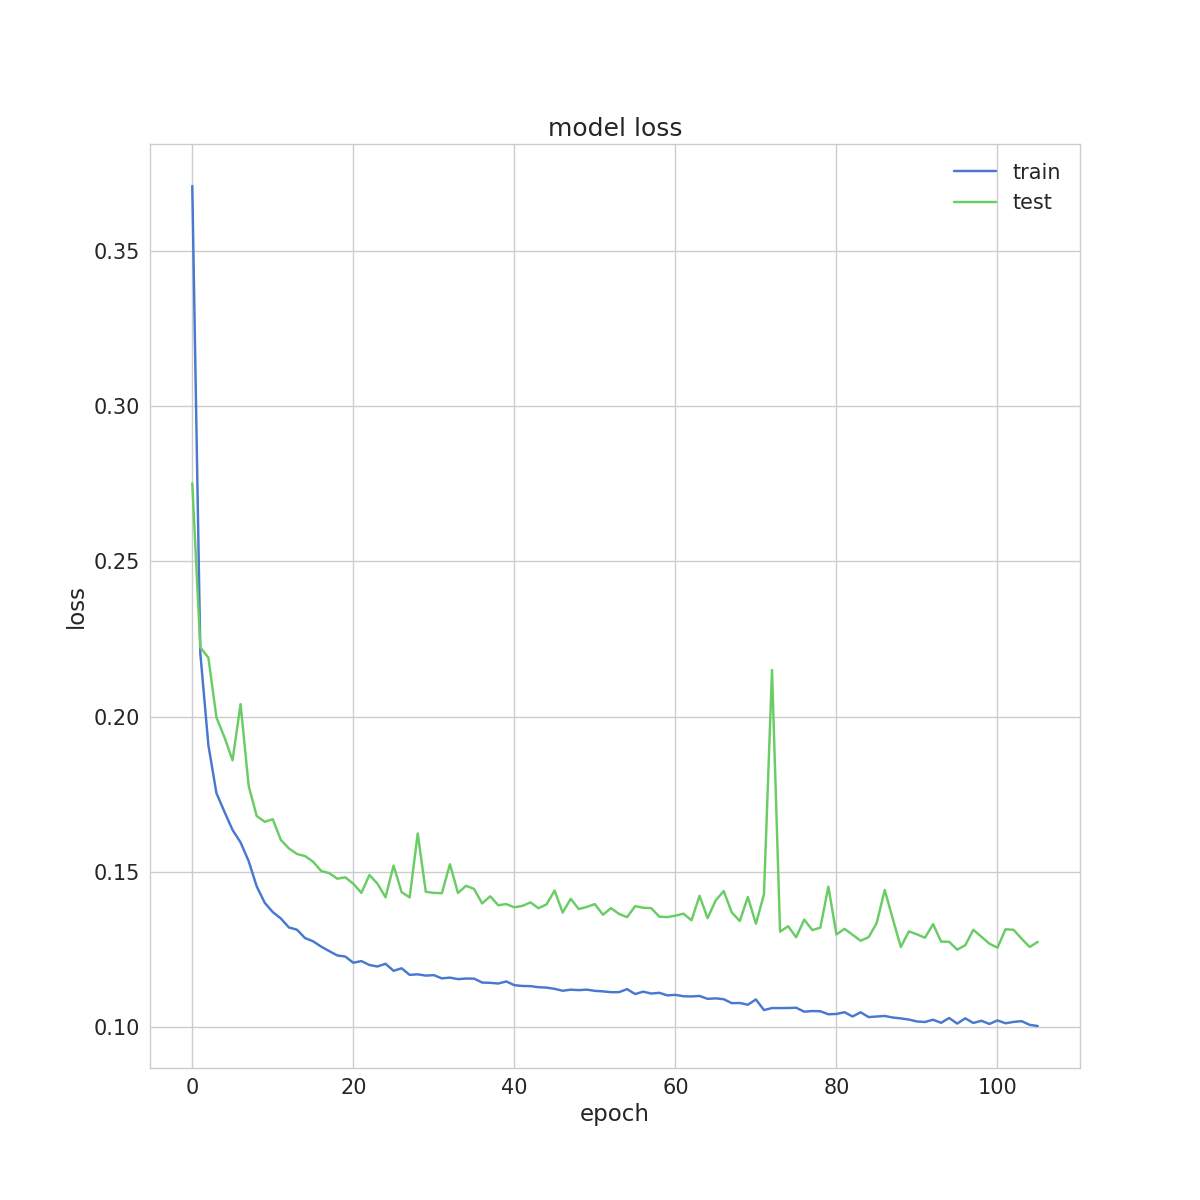

In [60]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
display()

In [61]:
predictions = autoencoder.predict(X_test)

In [62]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [63]:
error_df.describe()

Out[96]: 
 reconstruction_error true_class
count 56962.000000 56962.000000
mean 0.124903 0.001720
std 1.208267 0.041443
min 0.001008 0.000000
25% 0.025322 0.000000
50% 0.047679 0.000000
75% 0.091662 0.000000
max 62.189825 1.000000

## Reconstruction error without fraud

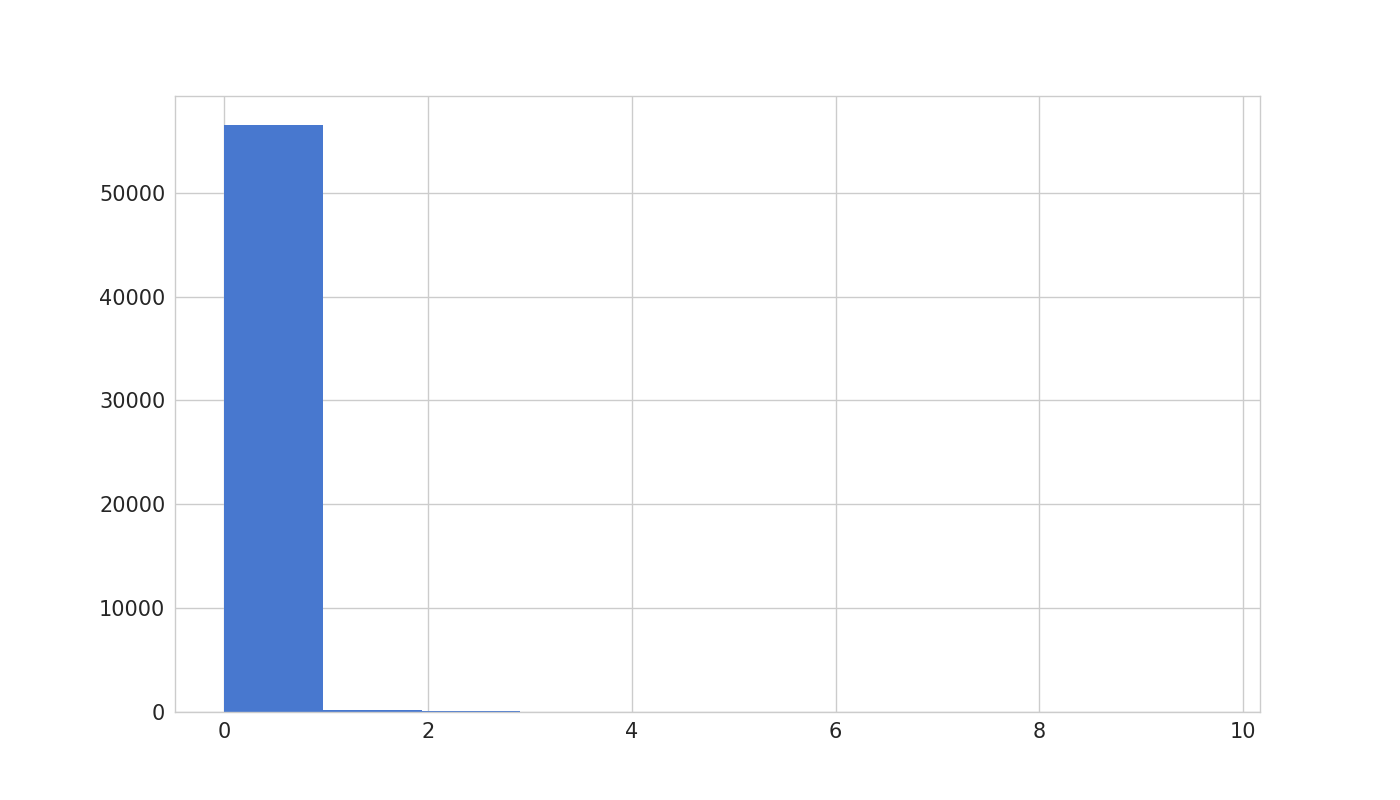

In [65]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
display()

## Reconstruction error with fraud

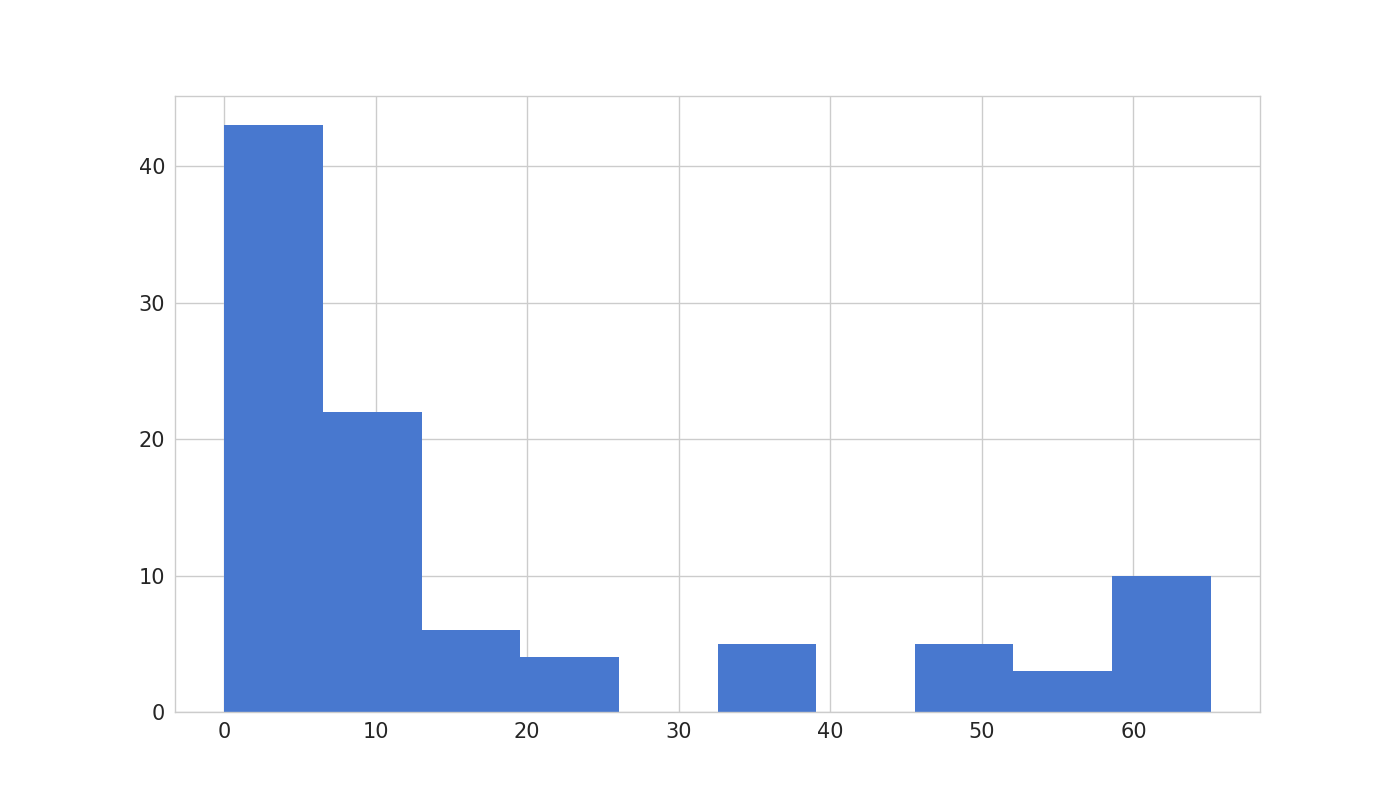

In [67]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
display()

In [68]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are not very useful in the case of anomaly detection, because the dataset is too imbalanced. Nonetheless, let's have a look at our ROC curve:

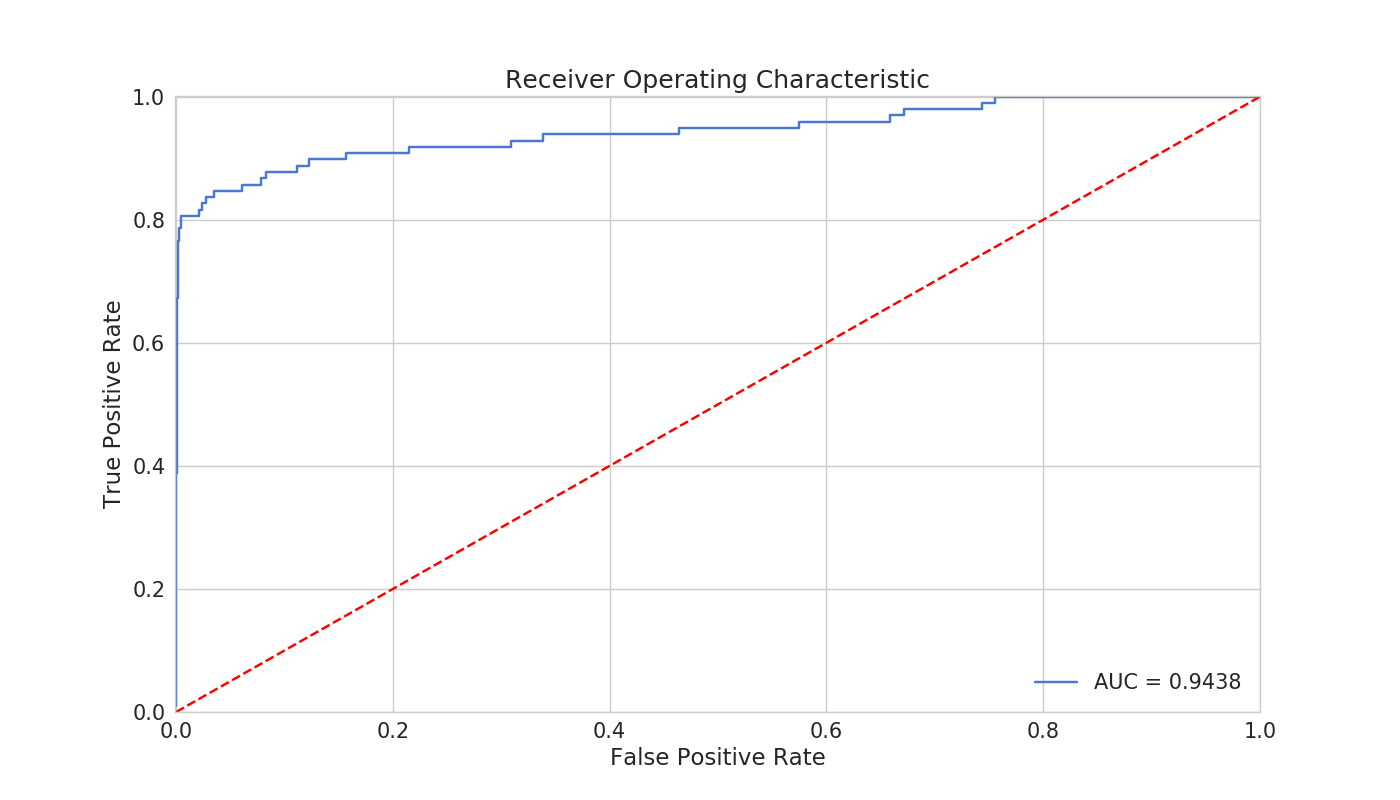

In [70]:
plt.clf()
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
display()

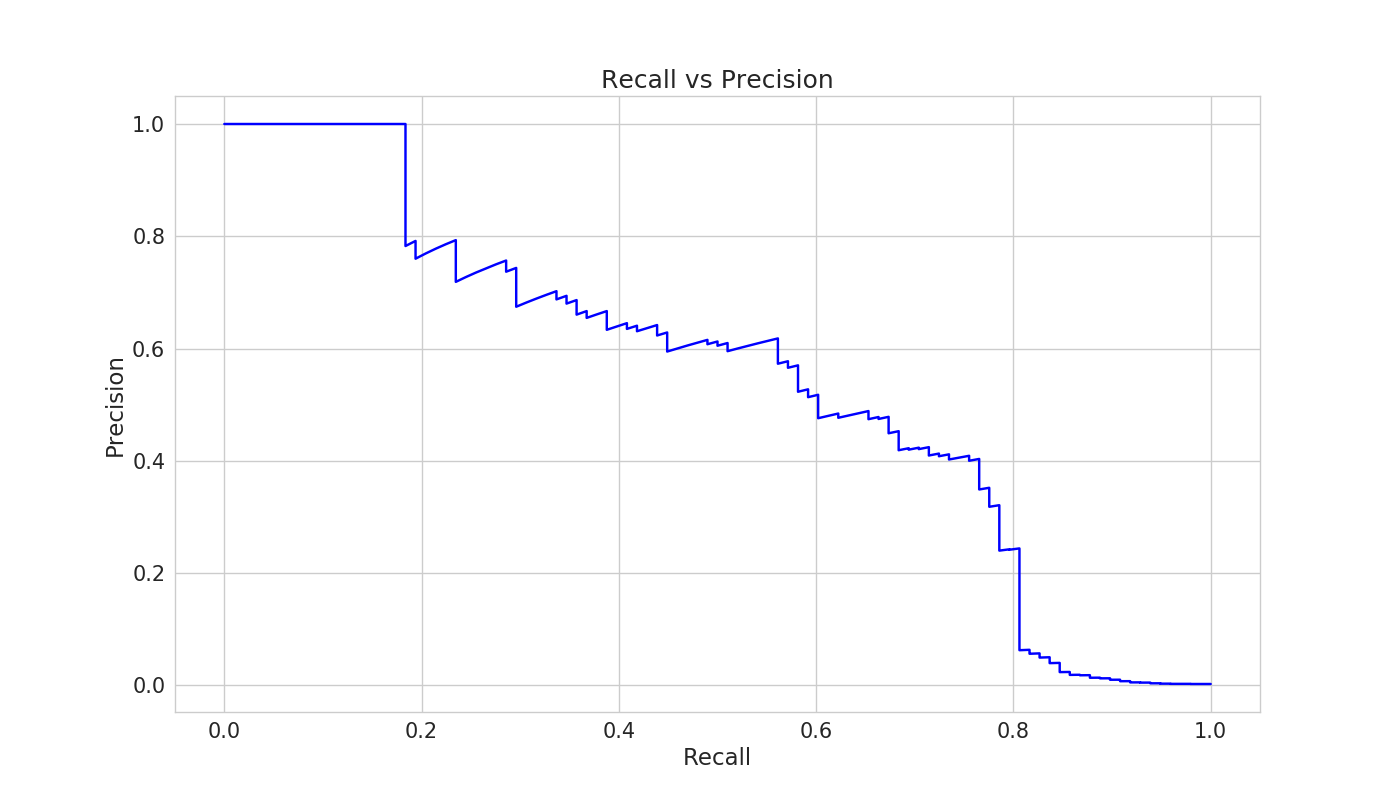

In [71]:
plt.clf()
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
display()

High precision indicates a low false positive rate, high recall a low false negative rate. Ideally we want both.

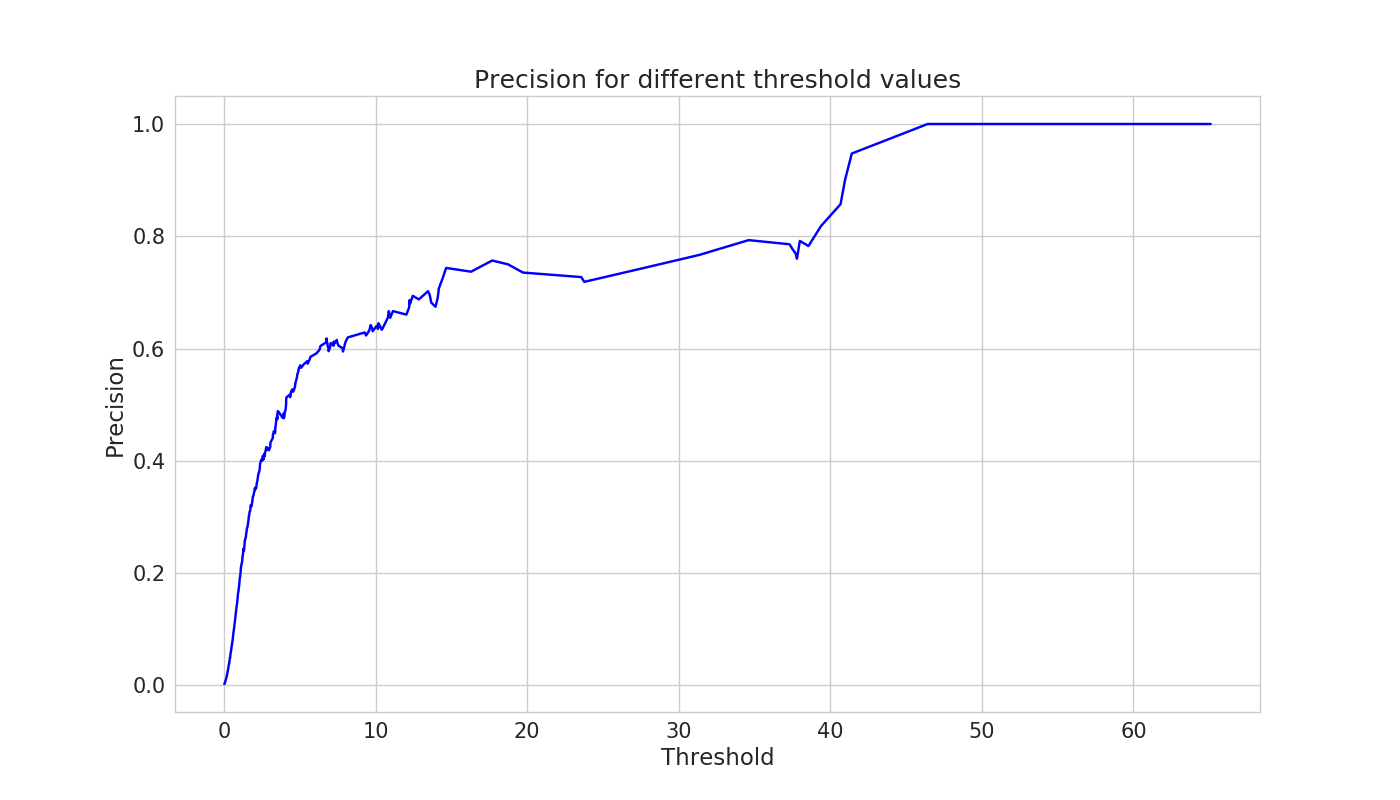

In [73]:
plt.clf()
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()
display()

As the reconstruction error increases, precision does as well.

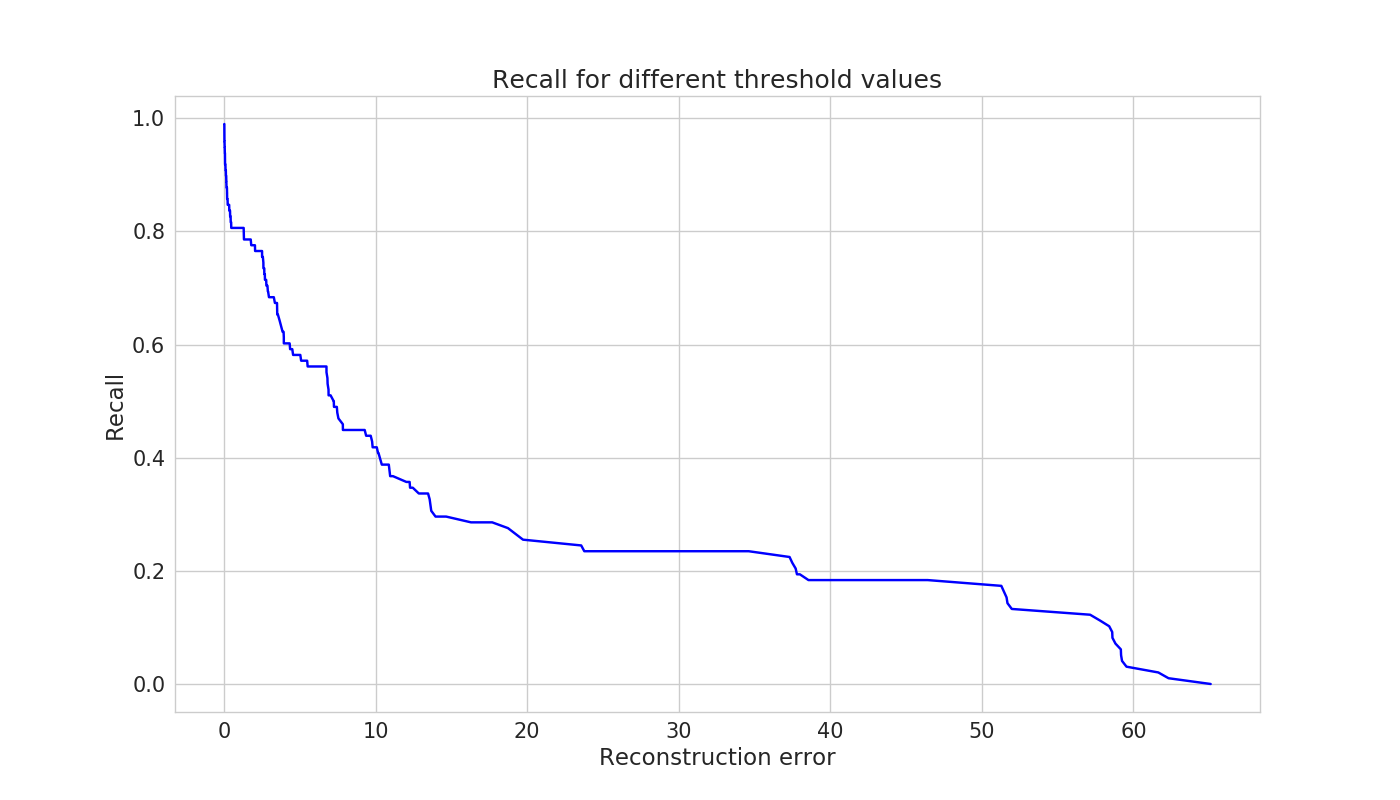

In [75]:
plt.clf()
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()
display()

As the reconstruction error increases, the recall decreases.

## Prediction

An autoencoder does not predict, it just reconstructs. In order to predict whether or not a transaction is normal or fraudulent, we calculate the reconstruction error from the transaction data. If the error is larger than a given threshold, we'll mark it as a fraud. In fact, our model was trained to reconstruct normal transactions. The reconstruction error will be higher for fraudulent ones.

In [78]:
threshold = 2.5

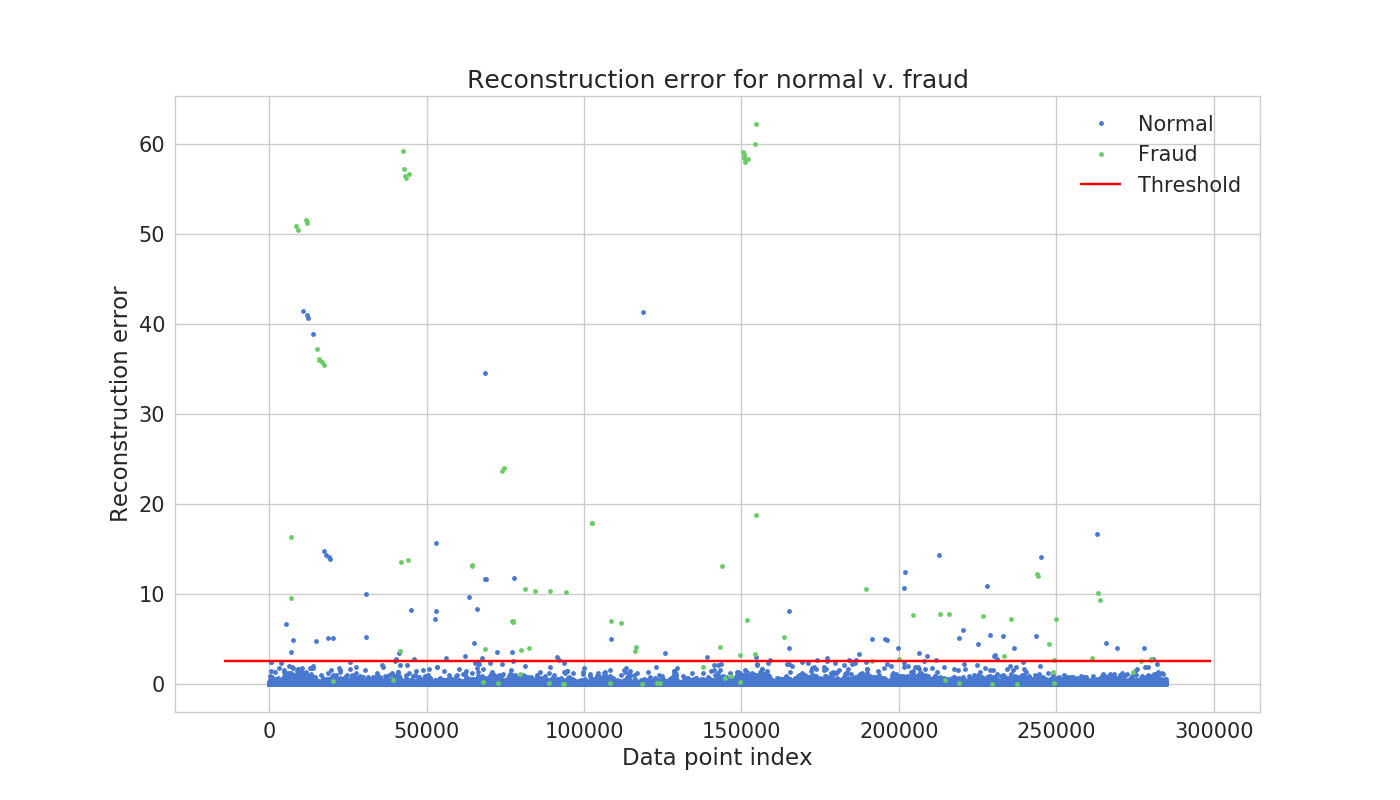

In [79]:
plt.clf()
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal v. fraud")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
display()

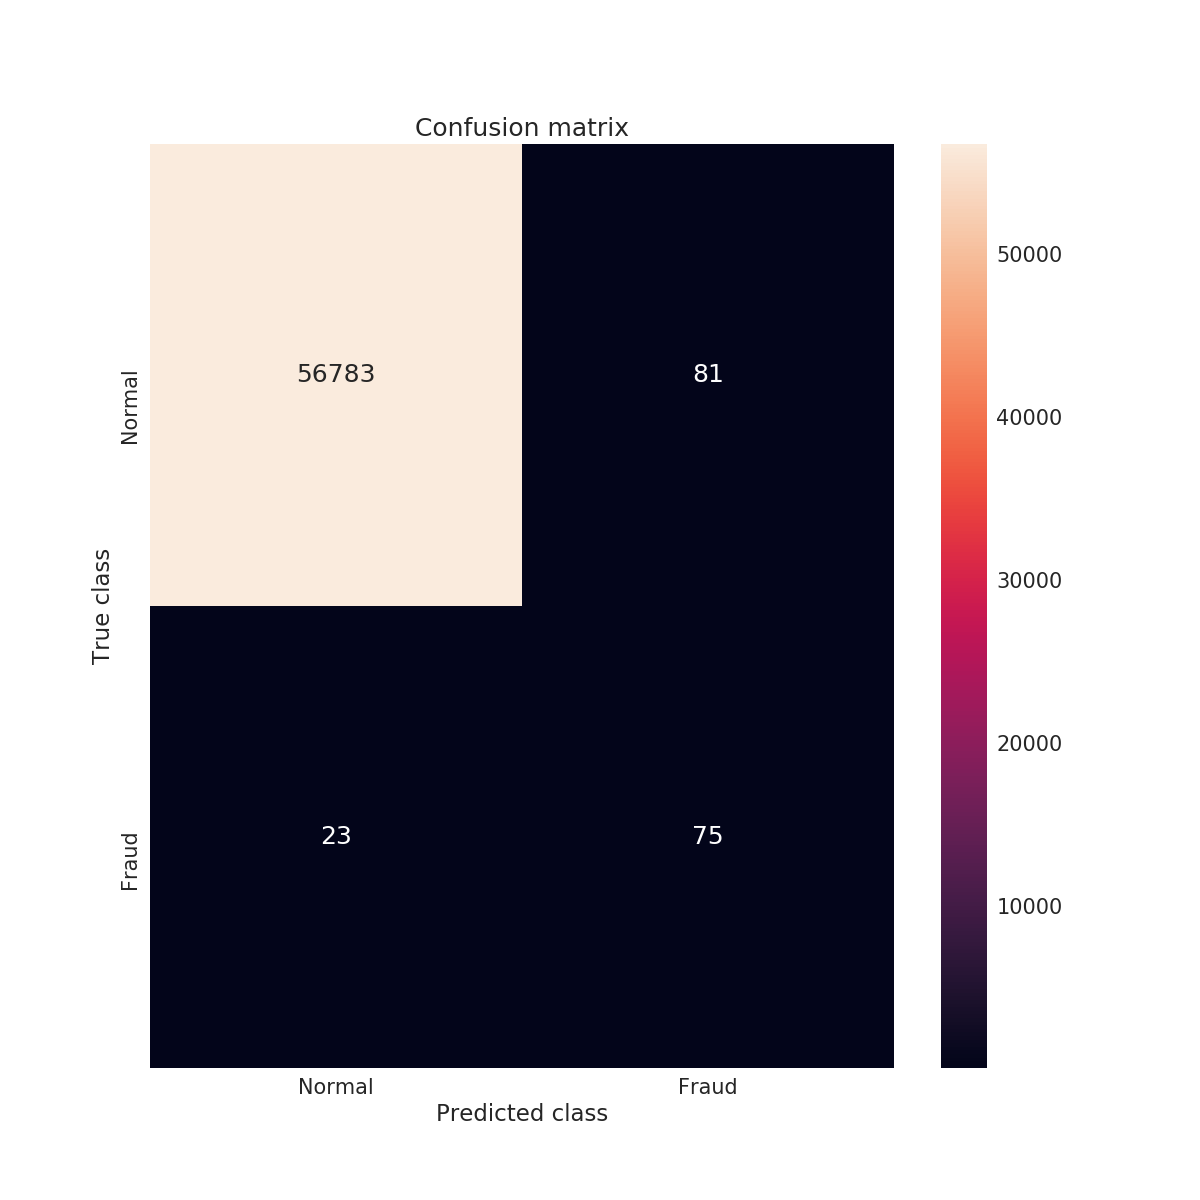

In [80]:
plt.clf()
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
display()